Generative Adversarial Network (GAN)

In [1]:
# jupternotebooks code that fits the display window to my screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [10]:
# import the libraries 
import shutil
import os

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, \
    BatchNormalization, UpSampling2D, Reshape, Conv2DTranspose, ReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
import os,random


INPUT_SIZE = 100
PLOT_FRECUENCY = 50

In [11]:
    # get our mnist data and reshape the data to be normalized with the range [-1, 1]
    # # normalizing helps the model faster approach to a global minima at error surface,
        # [-1, 1] increases the error surface
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)

    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    x_test = np.expand_dims(x_test, axis=-1)

In [12]:
latent_space = 100
# inverse convolutional neural network (i.e. take in a 
    #latent_vector and upsamples to produce an image)
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=3 * 3 * 384,input_dim=latent_space))
    generator.add(Reshape((3, 3, 384)))

    generator.add(Conv2DTranspose(192, 5, strides=1, padding='valid', activation='relu',))
    generator.add(BatchNormalization())

    
    generator.add(Conv2DTranspose(96, 5, strides=2, padding='same',activation='relu'))
    generator.add(BatchNormalization())

    # upsample to (28, 28, ...)
    generator.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh'
                            ))

    return generator


generator = create_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3456)              349056    
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 384)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 192)         1843392   
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 192)         768       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 96)        460896    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 96)        384       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)        

In [13]:
# standard convolutional neural network that classifies the images
# takes in an image and downsamples to produce a probability distribution


def create_discriminator():
    discriminator = Sequential()

    discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(1, kernel_size=4, strides=1, padding='same'))

    discriminator.add(Flatten())
    discriminator.add(Dense(units=2, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005, beta_1=0.5))
    return discriminator


discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 32)        544       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         131200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 128)        

In [14]:
def create_gan(generator, discriminator):
    # only train on the combo of true + fake images
    discriminator.trainable = False

    # Build the generator
    gan_input = Input(shape=(INPUT_SIZE,))
    # get a fake image
    generator_output = generator(gan_input)
    # 
    gan_output = discriminator(generator_output)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='categorical_crossentropy', 
                optimizer=Adam(lr=0.0005, beta_1=0.5))

    return gan


gan = create_gan(generator, discriminator)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         2656897   
_________________________________________________________________
sequential_3 (Sequential)    (None, 2)                 694763    
Total params: 3,351,660
Trainable params: 2,656,321
Non-trainable params: 695,339
_________________________________________________________________


In [15]:
ntrain = 10000
train_index = random.sample(range(0, x_train.shape[0]),ntrain)
XT = x_train[train_index,:,:,:]
n = XT.shape[0]


# pretrain the discriminator
# this will give a clearer gradient
# generate noise
noise = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise)
x = np.concatenate((XT, generated_images))
# generate labels
y = np.zeros([2*n,2])
# real images
y[:n,1]=1
# fake images
y[n:,0]=1

discriminator.trainable = True
discriminator.fit(x,y, batch_size=32,epochs=5,verbose=1)
y_hat = discriminator.predict(x)
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))





Train on 20000 samples
Epoch 1/5
20000/20000 [==============================] - ETA: 9:39 - loss: 0.788 - ETA: 3:25 - loss: 0.423 - ETA: 2:10 - loss: 0.307 - ETA: 1:38 - loss: 0.239 - ETA: 1:20 - loss: 0.195 - ETA: 1:08 - loss: 0.164 - ETA: 1:00 - loss: 0.142 - ETA: 55s - loss: 0.125 - ETA: 50s - loss: 0.11 - ETA: 47s - loss: 0.10 - ETA: 44s - loss: 0.09 - ETA: 41s - loss: 0.08 - ETA: 39s - loss: 0.08 - ETA: 38s - loss: 0.07 - ETA: 36s - loss: 0.07 - ETA: 35s - loss: 0.06 - ETA: 34s - loss: 0.06 - ETA: 33s - loss: 0.06 - ETA: 32s - loss: 0.05 - ETA: 31s - loss: 0.05 - ETA: 30s - loss: 0.05 - ETA: 30s - loss: 0.04 - ETA: 29s - loss: 0.04 - ETA: 28s - loss: 0.04 - ETA: 28s - loss: 0.04 - ETA: 27s - loss: 0.04 - ETA: 27s - loss: 0.04 - ETA: 26s - loss: 0.04 - ETA: 26s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 25s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 24s - loss: 0.03 - ETA: 23s - loss: 0.03 - ETA: 23s - loss: 

In [16]:
print("n",n)
print("noise",noise.shape)
print(generated_images.shape)
print("x",x.shape)
print("y",y.shape)

n 10000
noise (10000, 100)
(10000, 28, 28, 1)
x (20000, 28, 28, 1)
y (20000, 2)


In [17]:
print(y)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [18]:
def plot_loss(epoch,losses):
        plt.figure(figsize=(10,8))
        plt.title("Loss, Epochs 0-" + str(epoch))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

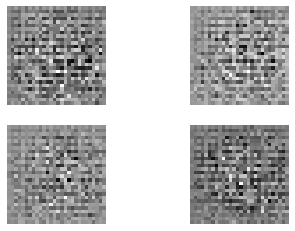

In [19]:
def save_imgs(epoch):
    r, c = 2,2
    noise = np.random.normal(0, 1, (r*c, 100))
    gen_imgs = generator.predict(noise)
    # rescale images
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    
save_imgs(1)
    


In [20]:
# loss vector
losses = {"d":[], "g":[]}

In [21]:
def training(epochs = 100, batch_size = 32, plt_freq=100):
    for epoch in range(1, epochs+1):
        
        
        # make generative images
        image_batch = x_train[np.random.randint(0,x_train.shape[0],size=batch_size),:,:,:]
        noise = np.random.uniform(0,1,size=[batch_size,100])
        generated_images = generator.predict(noise)
        

        
        # train the discriminator on generated images
        x = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*batch_size,2])
        y[0:batch_size,1]=1
        y[batch_size:,0]=1
        
        discriminator.trainable = True
        d_loss=discriminator.train_on_batch(x,y)
        losses["d"].append(d_loss)
        
        # train the generator-discriminator on input noise into non-generated output class
        # make new noise
        noise_train = np.random.uniform(0,1,size=[batch_size,100])
        # create new sample labels
        y2 = np.zeros([batch_size,2])
        y2[:,1] = 1
        
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise_train, y2)
        losses["g"].append(g_loss)
        
        if epoch%plt_freq==plt_freq-1:
            print ("%d [D loss: %f] [G loss: %g]" % (epoch, d_loss, g_loss))
            plot_loss(epoch, losses)
            save_imgs(epoch)
        


        
        

1 [D loss: 0.000001] [G loss: 0.475393]


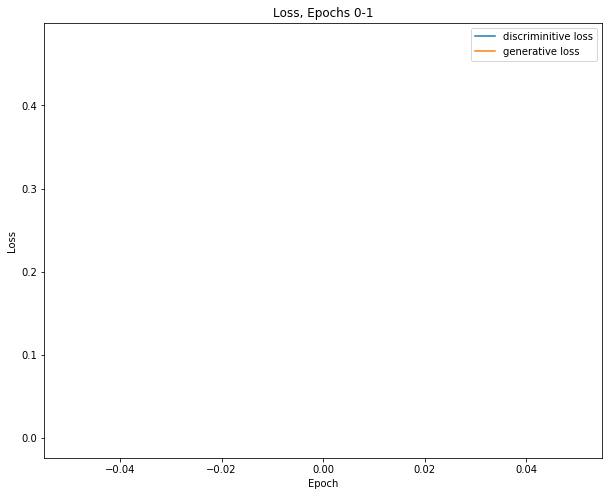

3 [D loss: 0.000002] [G loss: 5.12601e-06]


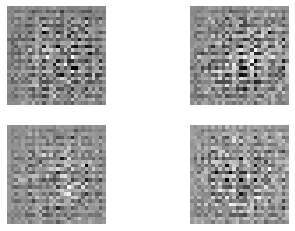

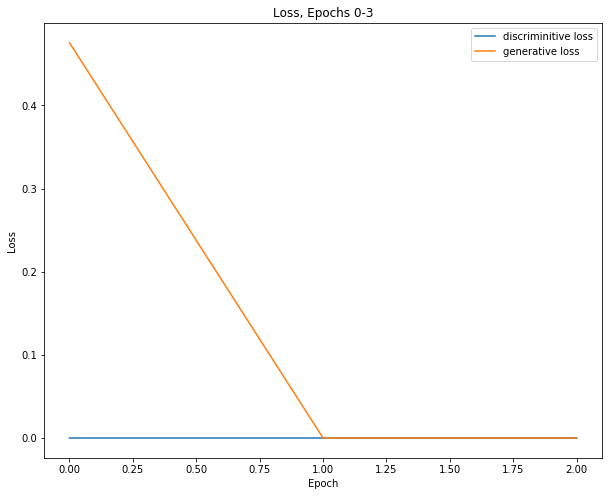

5 [D loss: 0.000002] [G loss: 4.85407e-06]


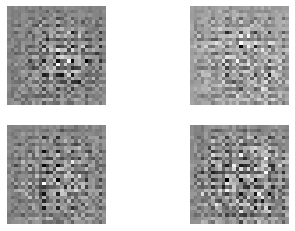

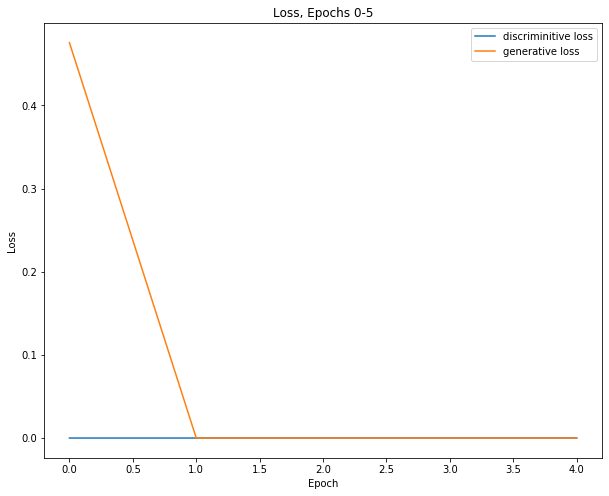

7 [D loss: 0.000002] [G loss: 3.84451e-06]


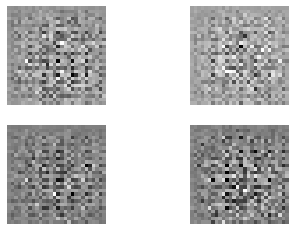

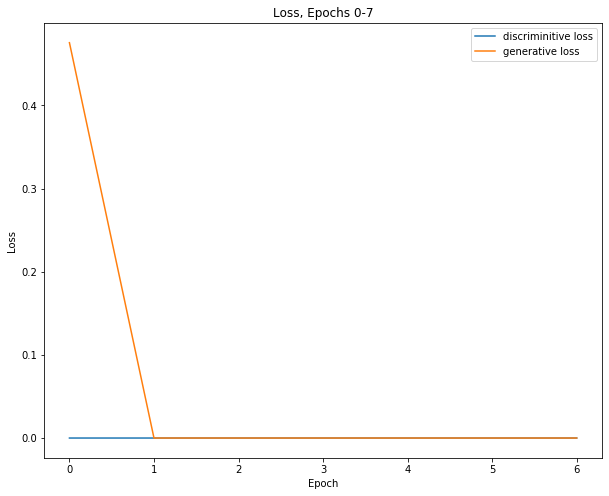

9 [D loss: 0.000002] [G loss: 3.5558e-06]


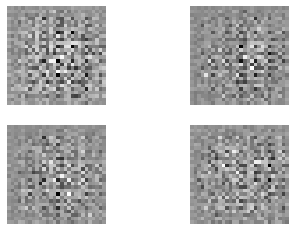

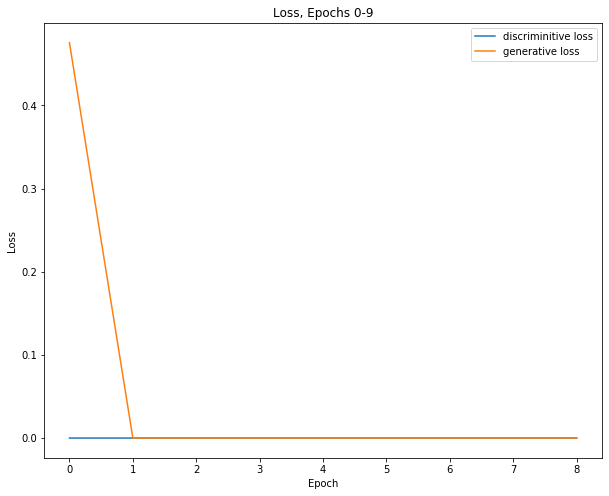

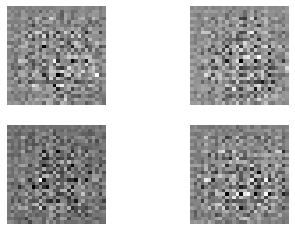

In [22]:
training(epochs = 10, batch_size = 32, plt_freq=2)

999 [D loss: 0.003282] [G loss: 5.97008]


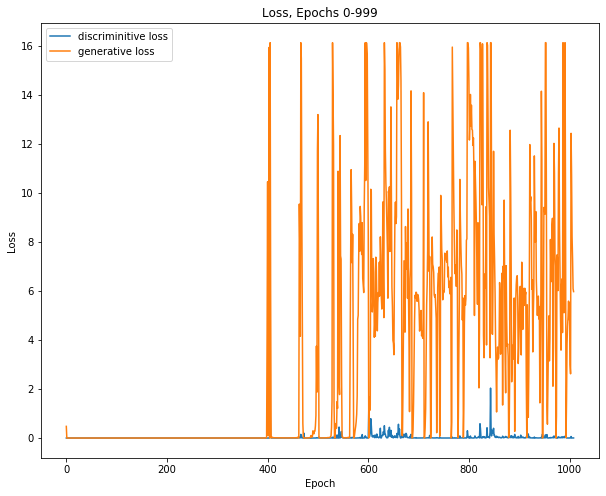

1999 [D loss: 0.003979] [G loss: 6.32708]


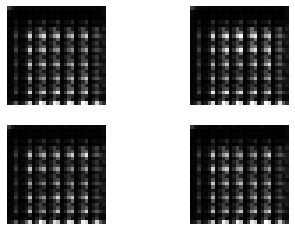

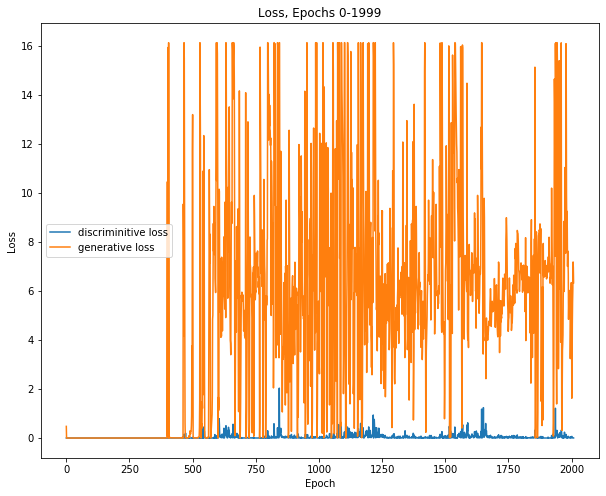

2999 [D loss: 0.009928] [G loss: 6.97464]


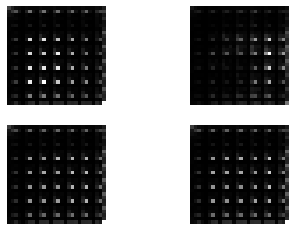

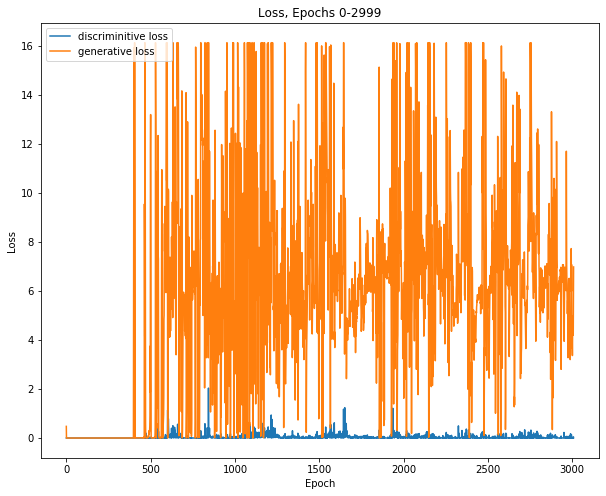

3999 [D loss: 0.038067] [G loss: 8.1948]


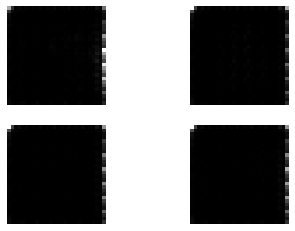

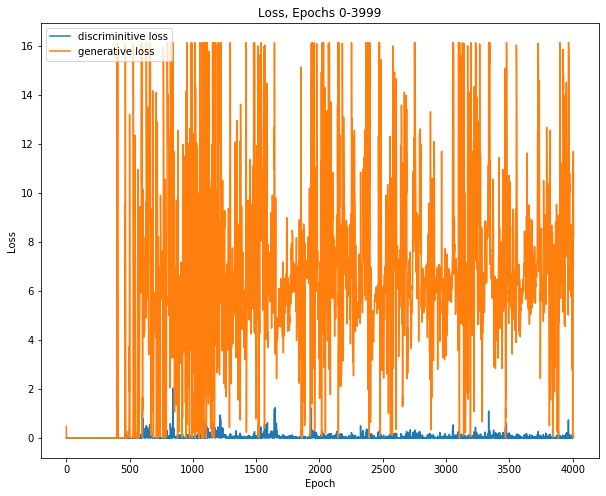

4999 [D loss: 0.003688] [G loss: 6.17735]


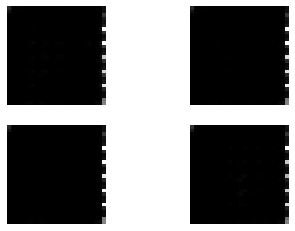

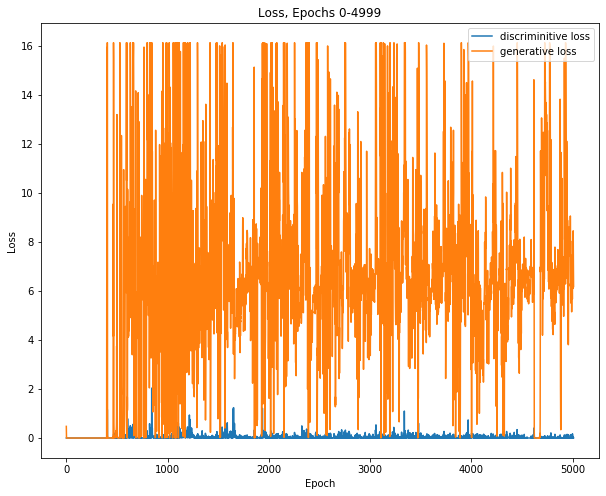

5999 [D loss: 0.000000] [G loss: 16.1181]


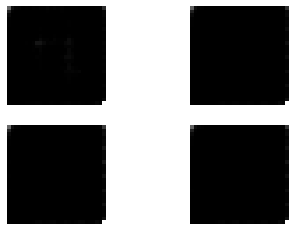

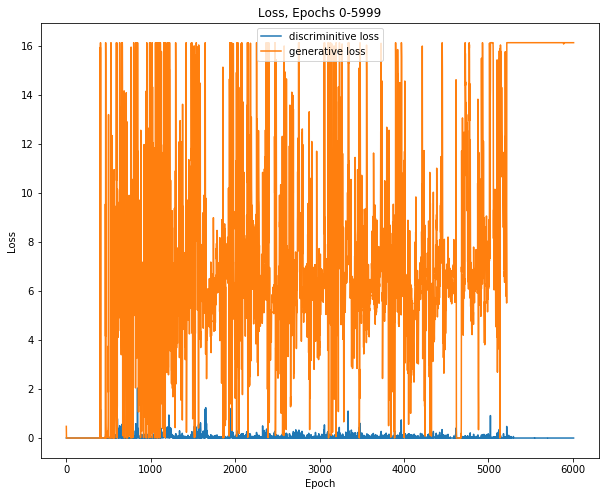

6999 [D loss: 0.000000] [G loss: 16.1181]


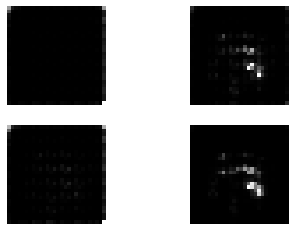

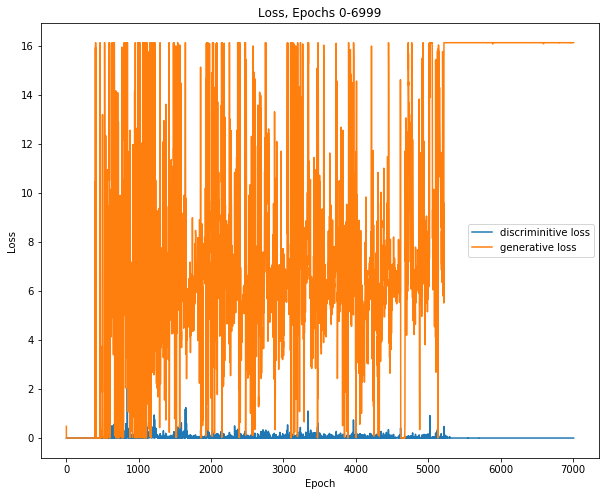

7999 [D loss: 0.038830] [G loss: 3.30719]


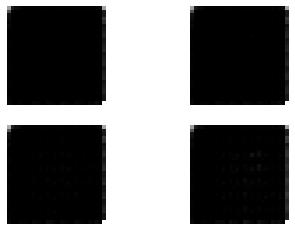

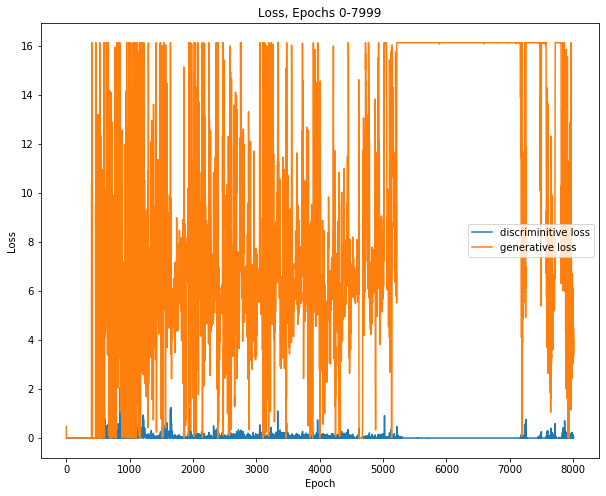

8999 [D loss: 0.000409] [G loss: 6.91733]


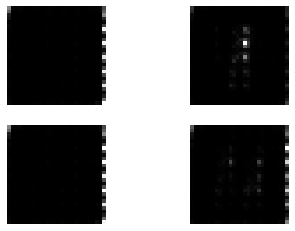

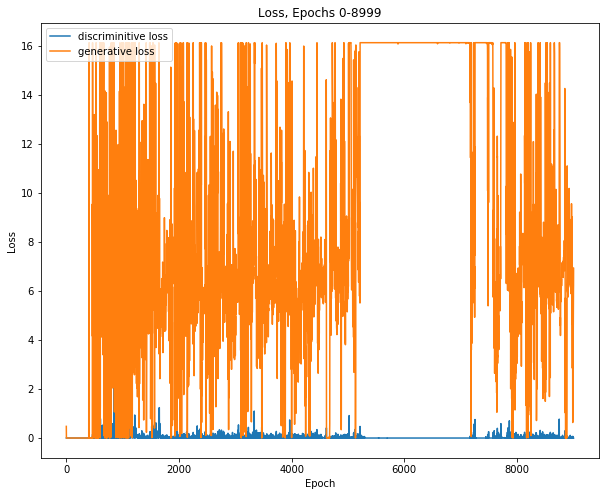

9999 [D loss: 0.000257] [G loss: 7.42975]


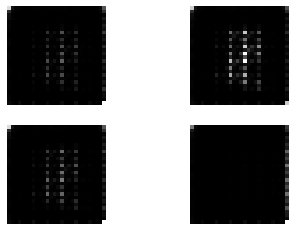

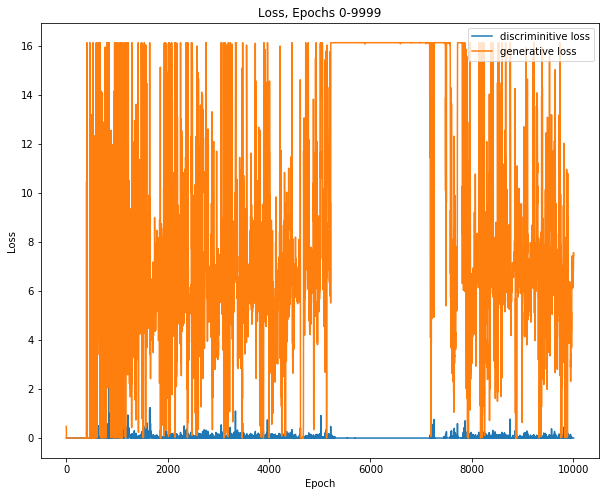

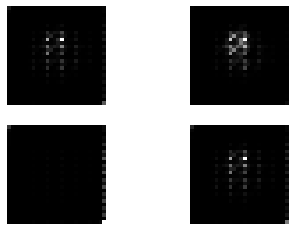

In [23]:
training(epochs = 10000, batch_size = 32, plt_freq=1000)